# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [63]:
import re, numpy as np, pandas as pd
from pathlib import Path
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# --------- configuration ----------
TRAIN_PATH = "train.csv"
TEST_PATH  = "test.csv"
SUBMIT_OUT = "submission_svd_lr.csv"
USE_TFIDF  = True               # ← enable/disable TF-IDF preprocessing SVD
N_COMP     = 64                 # ← 64/128/256/384/512
C_LOGREG   = 0.5                # ← regularization coefficient
# ----------------------------

# 0) data loading
try:
    train
except NameError:
    train = pd.read_csv(TRAIN_PATH)
try:
    test
except NameError:
    test  = pd.read_csv(TEST_PATH)

# 1) preprocessing functions
TITLE_MAP = {"Mlle":"Miss","Ms":"Miss","Mme":"Mrs","Lady":"Noble","Countess":"Noble","Sir":"Noble","Don":"Noble","Dona":"Noble","Jonkheer":"Noble",
             "Capt":"Officer","Col":"Officer","Major":"Officer","Dr":"Officer","Rev":"Officer"}

def extract_title(name: str) -> str:
    m = re.search(r",\s*([^\.]+)\.", name)
    title = m.group(1).strip() if m else "TitleNA"
    title = TITLE_MAP.get(title, title)
    return f"TITLE_{title}"

def surname_from_name(name: str) -> str:
    s = name.split(",")[0].strip().upper()
    s = re.sub(r"[^A-Z]", "", s)
    return s if s else "SURNAME_NA"

def normalize_ticket(s: str) -> str:
    if pd.isna(s): return "TICKET_NA"
    s = s.upper()
    s = re.sub(r"[^A-Z0-9]", "", s)
    return s if s else "TICKET_NA"

def extract_deck(cabin: str) -> str:
    if pd.isna(cabin) or not str(cabin).strip():
        return "DECK_NA"
    first = str(cabin).split()[0]
    letter = first[0].upper()
    return f"DECK_{letter}" if letter in list("ABCDEFGT") else "DECK_OTHER"

In [64]:
def split_cabins(cabin_str: str):
    """ pretty standard cabin prefix extraction """
    if pd.isna(cabin_str) or not str(cabin_str).strip():
        return []
    toks = str(cabin_str).upper().split()
    clean = []
    for t in toks:
        m = re.match(r'^([A-Z])(\d+)$', t)
        if m:
            clean.append(m.group(1) + m.group(2))
        else:
            m2 = re.match(r'^([A-Z])$', t)
            if m2:
                clean.append(m2.group(1))
    return clean

def build_shared_cabins_set(df: pd.DataFrame):
    """ passenger is sharing a cabin """
    from collections import Counter
    cnt = Counter()
    for cab in df["Cabin"].fillna("").astype(str):
        for c in split_cabins(cab):
            cnt[c] += 1
    return {c for c, k in cnt.items() if k >= 2}

def build_cabin_composition(df):
    """ this is my try to enrich data with relations between cabin occupants """
    # splitting cabins into list
    df = df.copy()
    df["CabinsList"] = df["Cabin"].apply(split_cabins)
    
    # mapping creation
    from collections import defaultdict
    cab_to_pass = defaultdict(list)
    for idx, row in df.iterrows():
        for c in row["CabinsList"]:
            cab_to_pass[c].append(idx)
    
    comp_tokens = []
    for idx, row in df.iterrows():
        toks = set()
        fam = row["FamilyGroup"]
        
        neighbors = set()
        for c in row["CabinsList"]:
            neighbors.update(cab_to_pass[c])
        neighbors.discard(idx)
        
        if not neighbors:
            toks.add("CABCOMP_SOLO")  # single cabin
        else:
            fam_count = 0
            male_count, female_count, child_count = 0,0,0
            for nb in neighbors:
                if df.loc[nb,"FamilyGroup"] == fam:
                    fam_count += 1
                if df.loc[nb,"Sex"] == "male" and df.loc[nb,"Age"] >= 18:
                    male_count += 1
                if df.loc[nb,"Sex"] == "female":
                    female_count += 1
                if df.loc[nb,"Age"] < 18:
                    child_count += 1
            if fam_count > 0:
                toks.add("CABCOMP_FAM")
            if male_count > 0:
                toks.add("CABCOMP_WITHMALE")
            if female_count > 0:
                toks.add("CABCOMP_WITHFEM")
            if child_count > 0:
                toks.add("CABCOMP_WITHCHILD")
        
        comp_tokens.append(list(toks))
    
    return comp_tokens

def preprocess(df: pd.DataFrame, *, age_medians=None, age_global=None,
               age_bins_edges=None, fare_bins_edges=None):
    out = df.copy()

    out["Embarked"] = out["Embarked"].fillna(out["Embarked"].mode().iloc[0]).astype(str).str.upper()
    out["Sex"] = out["Sex"].astype(str).str.lower()
    out["Pclass"] = out["Pclass"].astype(int)

    out["Title"] = out["Name"].apply(extract_title)
    out["Surname"] = out["Name"].apply(surname_from_name)
    out["FamilySize"] = out["SibSp"].fillna(0) + out["Parch"].fillna(0) + 1
    out["FamilyGroup"] = out["Surname"] + "_" + out["FamilySize"].astype(int).astype(str)
    out.loc[out["Surname"]=="SURNAME_NA", "FamilyGroup"] = "FAM_NA"
    
    out["TicketGroup"] = out["Ticket"].apply(normalize_ticket)
    out["Deck"] = out["Cabin"].apply(extract_deck)

    # --- age impute ---
    if age_medians is None:
        age_medians = out.groupby(["Title","Sex","Pclass"])["Age"].median()
    if age_global is None:
        age_global = out["Age"].median()
    def impute_age(r):
        if pd.isna(r["Age"]):
            try:
                return age_medians.loc[r["Title"], r["Sex"], r["Pclass"]]
            except KeyError:
                return age_global
        return r["Age"]
    out["Age"] = out.apply(impute_age, axis=1).fillna(age_global)

    # --- binning ---
    if age_bins_edges is None:
        age_bins_edges  = np.unique(np.quantile(out["Age"],  [0,.2,.4,.6,.8,1.0]))
    out["Fare"] = out["Fare"].fillna(out["Fare"].median())
    if fare_bins_edges is None:
        fare_bins_edges = np.unique(np.quantile(out["Fare"], [0,.2,.4,.6,.8,1.0]))

    out["AgeBin"]  = pd.cut(out["Age"],  bins=age_bins_edges,  include_lowest=True, labels=False).astype("Int64").fillna(0).astype(int)
    out["FareBin"] = pd.cut(out["Fare"], bins=fare_bins_edges, include_lowest=True, labels=False).astype("Int64").fillna(0).astype(int)

    # --- base items ---
    out["Item_Sex"]      = "SEX_"    + out["Sex"]
    out["Item_Pclass"]   = "PCLASS_" + out["Pclass"].astype(str)
    out["Item_Embarked"] = "EMB_"    + out["Embarked"].astype(str)
    out["Item_Family"]   = "FAM_"    + out["FamilyGroup"]
    out["Item_Ticket"]   = "TIC_"    + out["TicketGroup"]
    out["Item_Deck"]     = out["Deck"]
    out["Item_AgeBin"]   = "AGE_"    + out["AgeBin"].astype(str)
    out["Item_FareBin"]  = "FARE_"   + out["FareBin"].astype(str)
    out["Item_Title"]    = out["Title"]

    build_shared_cabins_set(train)

    # --- shared cabin features ---
    # 1) binary token shared / not shared
    def has_shared(cab_str):
        if shared_cabins_set is None:
            return False
        cs = split_cabins(cab_str)
        return any(c in shared_cabins_set for c in cs)
    out["Item_SharedCabin"] = np.where(out["Cabin"].apply(has_shared), "CABSH_Y", "CABSH_N")

    # 2) CabinGroup: if there is a ≥1 shared cabin, take minimal by lexicography; else CABG_NONE
    def cabin_group_token(cab_str):
        if shared_cabins_set is None:
            return "CABG_NONE"
        cs = sorted([c for c in split_cabins(cab_str) if c in shared_cabins_set])
        return ("CABG_" + cs[0]) if cs else "CABG_NONE"
    out["Item_CabinGroup"] = out["Cabin"].apply(cabin_group_token)

    return out, age_medians, age_global, age_bins_edges, fare_bins_edges

# shared_cabins = build_shared_cabins_set(train)
# shared_cabins = build_cabin_composition(train)

train_pp, age_medians, age_global, age_edges, fare_edges = preprocess(
    train
)
test_pp,  _,           _,          _,        _           = preprocess(
    test,  age_medians=age_medians, age_global=age_global,
    age_bins_edges=age_edges, fare_bins_edges=fare_edges
)

item_cols = [
    "Item_Sex","Item_Pclass","Item_Embarked",
    "Item_Family","Item_Ticket","Item_Deck",
    "Item_AgeBin","Item_FareBin","Item_Title",
    "Item_SharedCabin","Item_CabinGroup"
]

In [65]:
test_pp

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,Item_Pclass,Item_Embarked,Item_Family,Item_Ticket,Item_Deck,Item_AgeBin,Item_FareBin,Item_Title,Item_SharedCabin,Item_CabinGroup
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,...,PCLASS_3,EMB_Q,FAM_KELLY_1,TIC_330911,DECK_NA,AGE_3,FARE_0,TITLE_Mr,CABSH_N,CABG_NONE
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,...,PCLASS_3,EMB_S,FAM_WILKES_2,TIC_363272,DECK_NA,AGE_4,FARE_0,TITLE_Mrs,CABSH_N,CABG_NONE
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,...,PCLASS_2,EMB_Q,FAM_MYLES_1,TIC_240276,DECK_NA,AGE_4,FARE_1,TITLE_Mr,CABSH_N,CABG_NONE
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,...,PCLASS_3,EMB_S,FAM_WIRZ_1,TIC_315154,DECK_NA,AGE_2,FARE_1,TITLE_Mr,CABSH_N,CABG_NONE
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,...,PCLASS_3,EMB_S,FAM_HIRVONEN_3,TIC_3101298,DECK_NA,AGE_1,FARE_2,TITLE_Mrs,CABSH_N,CABG_NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,26.0,0,0,A.5. 3236,8.0500,NaN,...,PCLASS_3,EMB_S,FAM_SPECTOR_1,TIC_A53236,DECK_NA,AGE_1,FARE_1,TITLE_Mr,CABSH_N,CABG_NONE
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,...,PCLASS_1,EMB_C,FAM_OLIVAYOCANA_1,TIC_PC17758,DECK_C,AGE_3,FARE_4,TITLE_Noble,CABSH_N,CABG_NONE
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,...,PCLASS_3,EMB_S,FAM_SAETHER_1,TIC_SOTONOQ3101262,DECK_NA,AGE_3,FARE_0,TITLE_Mr,CABSH_N,CABG_NONE
416,1308,3,"Ware, Mr. Frederick",male,26.0,0,0,359309,8.0500,NaN,...,PCLASS_3,EMB_S,FAM_WARE_1,TIC_359309,DECK_NA,AGE_1,FARE_1,TITLE_Mr,CABSH_N,CABG_NONE


In [66]:
# def preprocess(df: pd.DataFrame, *, age_medians=None, age_global=None,
#                age_bins_edges=None, fare_bins_edges=None):
#     out = df.copy()
#     out["Embarked"] = out["Embarked"].fillna(out["Embarked"].mode().iloc[0]).astype(str).str.upper()
#     out["Sex"] = out["Sex"].astype(str).str.lower()
#     out["Pclass"] = out["Pclass"].astype(int)
# 
#     out["Title"] = out["Name"].apply(extract_title)
#     out["Surname"] = out["Name"].apply(surname_from_name)
#     out["FamilySize"] = out["SibSp"].fillna(0) + out["Parch"].fillna(0) + 1
#     out["FamilyGroup"] = out["Surname"] + "_" + out["FamilySize"].astype(int).astype(str)
#     out.loc[out["Surname"]=="SURNAME_NA", "FamilyGroup"] = "FAM_NA"
# 
#     out["TicketGroup"] = out["Ticket"].apply(normalize_ticket)
#     out["Deck"] = out["Cabin"].apply(extract_deck)
# 
#     # Age impute
#     if age_medians is None:
#         age_medians = out.groupby(["Title","Sex","Pclass"])["Age"].median()
#     if age_global is None:
#         age_global = out["Age"].median()
#     def impute_age(r):
#         if pd.isna(r["Age"]):
#             try:
#                 return age_medians.loc[r["Title"], r["Sex"], r["Pclass"]]
#             except KeyError:
#                 return age_global
#         return r["Age"]
#     out["Age"] = out.apply(impute_age, axis=1).fillna(age_global)
# 
#     # Binning edges
#     if age_bins_edges is None:
#         age_bins_edges  = np.unique(np.quantile(out["Age"],  [0,.2,.4,.6,.8,1.0]))
#     if fare_bins_edges is None:
#         out["Fare"] = out["Fare"].fillna(out["Fare"].median())
#         fare_bins_edges = np.unique(np.quantile(out["Fare"], [0,.2,.4,.6,.8,1.0]))
#     else:
#         out["Fare"] = out["Fare"].fillna(out["Fare"].median())
# 
#     out["AgeBin"]  = pd.cut(out["Age"],  bins=age_bins_edges,  include_lowest=True, labels=False).astype("Int64").fillna(0).astype(int)
#     out["FareBin"] = pd.cut(out["Fare"], bins=fare_bins_edges, include_lowest=True, labels=False).astype("Int64").fillna(0).astype(int)
# 
#     # items
#     out["Item_Sex"]      = "SEX_"    + out["Sex"]
#     out["Item_Pclass"]   = "PCLASS_" + out["Pclass"].astype(str)
#     out["Item_Embarked"] = "EMB_"    + out["Embarked"].astype(str)
#     out["Item_Family"]   = "FAM_"    + out["FamilyGroup"]
#     out["Item_Ticket"]   = "TIC_"    + out["TicketGroup"]
#     out["Item_Deck"]     = out["Deck"]
#     out["Item_AgeBin"]   = "AGE_"    + out["AgeBin"].astype(str)
#     out["Item_FareBin"]  = "FARE_"   + out["FareBin"].astype(str)
#     out["Item_Title"]    = out["Title"]
#     return out, age_medians, age_global, age_bins_edges, fare_bins_edges
# 
# # 2) preprocessing: train -> freeze stats -> test
# train_pp, age_medians, age_global, age_edges, fare_edges = preprocess(train)
# test_pp,  _,           _,          _,        _           = preprocess(
#     test, age_medians=age_medians, age_global=age_global,
#     age_bins_edges=age_edges, fare_bins_edges=fare_edges
# )
# 
# item_cols = ["Item_Sex","Item_Pclass","Item_Embarked",
#              "Item_Family","Item_Ticket","Item_Deck","Item_AgeBin","Item_FareBin","Item_Title"]


In [67]:
def rows_to_dicts(df):
    return [{ r[c]: 1 for c in item_cols } for _, r in df[item_cols].iterrows()]

dv = DictVectorizer(dtype=np.float32, sparse=True)
X_train = dv.fit_transform(rows_to_dicts(train_pp))
y_train = train_pp["Survived"].astype(int).values
X_test  = dv.transform(rows_to_dicts(test_pp))

print("Shapes:", X_train.shape, X_test.shape, "| nnz train:", X_train.nnz)

Shapes: (891, 1418) (418, 1418) | nnz train: 9801


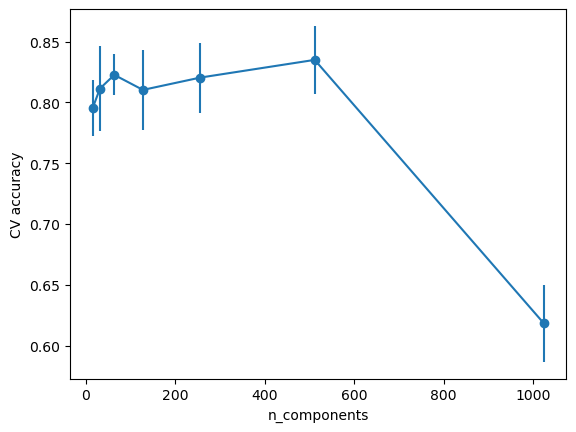

In [68]:
# 3) pipeline -> fit -> predict
ks = [16, 32, 64, 128, 256, 512, 1024]
means, stds = [], []

for k in ks:
    tfidf = TfidfTransformer(sublinear_tf=True)  # lowering weight from most frequent tokens
    svd = TruncatedSVD(n_components=k, random_state=42)
    scaler = StandardScaler() 
    lr = LogisticRegression(C=C_LOGREG, max_iter=2000, solver="lbfgs")
    
    if USE_TFIDF:
        pipe = make_pipeline(tfidf, svd, scaler, lr)
    else:
        pipe = make_pipeline(svd, scaler, lr)
        
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
    means.append(scores.mean()); stds.append(scores.std())

plt.errorbar(ks, means, yerr=stds, marker='o')
plt.xlabel("n_components")
plt.ylabel("CV accuracy")
plt.show()

In [69]:
# 3) pipeline -> fit -> predict
steps = []
if USE_TFIDF:
    steps.append(("tfidf", TfidfTransformer(sublinear_tf=True)))  # уменьшает вес частых токенов
steps += [
    ("svd", TruncatedSVD(n_components=N_COMP, random_state=42)),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(C=C_LOGREG, max_iter=2000, solver="lbfgs"))
]
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps)
pipe.fit(X_train, y_train)

# 4) submit
test_pred = pipe.predict(X_test).astype(int)
subm = pd.DataFrame({"PassengerId": test_pp["PassengerId"].astype(int), "Survived": test_pred})
subm.to_csv(SUBMIT_OUT, index=False)
print("Saved:", SUBMIT_OUT, "| shape:", subm.shape)
subm.head()

Saved: submission_svd_lr.csv | shape: (418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
